# Decay Curves

## Description

Decay curves occur when the indoor temperature in a building exponentially decays to meet a lower outdoor temperature. They can be used to obtain an estimate for RC, where R is the thermal resistivity and C is the capacitancy of the building. The physical equation that describes a decay curve is as follows:

$$\theta(t)=\theta_0\exp{\frac{-t}{\tau}}$$where$$\theta(t)=T_{ext}-T_{in}$$


### Filtering Parameters

In order to find decay curves in a building a data filtering step takes place. Various parameters are used to filter the data and find suitable curves. These parameters are listed here.

1. __setpoint_derivative_threshold__: The change in indoor heating setpoint. Decay curves occur after a heating setpoint drop. Finding a large drop would result in a larger decay curve.

2. __T_out_stationarity__: An assumption in this modeling method is that the outdoor temperature is constant. This filter therefore checks for time periods where the mean of the outdoor temperature is relatively constant.

3. __T_in_derivative_threshold__: For a decay curve to have occured, the indoor temperature must have dropped. This check asserts that is the case.

4. __T_in_out_diff__: The difference between the outdoor and indoor temperature. The greater the difference, the steaper the decay curve.

5. __proportion_heating__: The formulated equation for the decay curves does not account for heating input into the system. This value should therefore be close to 0.

6. __max_duration__: The maximum time duration of a decay curve.
7. __min_duration__: The minimum time duration of a decay curve.

## Example

### 1. Import the required libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scripts.filters import months, hours, decay_curve_params
import scripts.decay_curves as dc
import scripts.preprocessing as pp

### 2. Load the building data into memory

Edit the filename to chang which building is being evaluated. The example buildings included in this repo can be found  in `data/raw_data/Toronto`. Note that not all of the building files have decay curves.

In [2]:
filename = "a937d992bbae47858967713080c8e8173b331e9c.csv"
df = pp.load_building_data(filename)

### 3. Extract decay curves

In [3]:
intervals = dc.select_intervals(months, hours, decay_curve_params, df)
print(len(intervals), "Decay Curves Were Found")

42 Decay Curves Were Found


### 4. Run the model fitting and plot the results

/home/evan/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


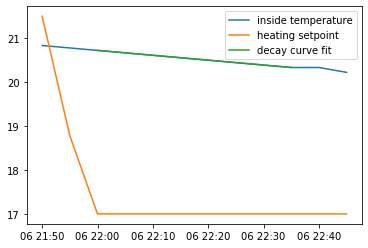

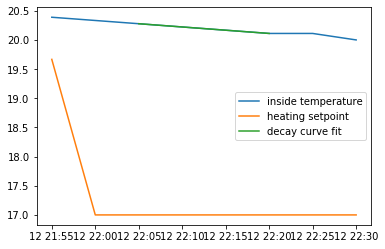

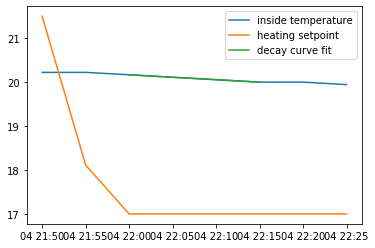

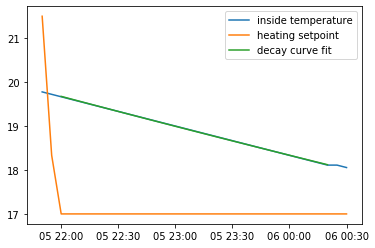

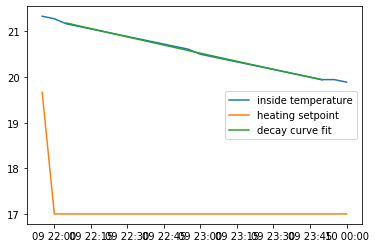

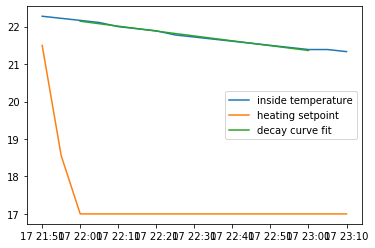

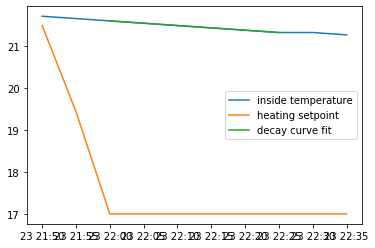

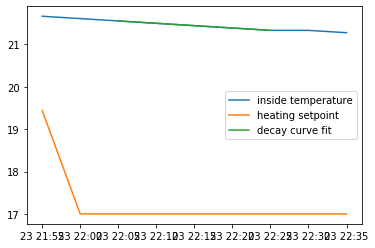

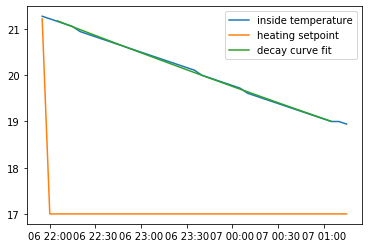

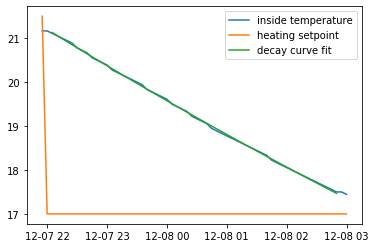

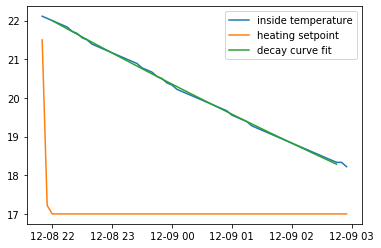

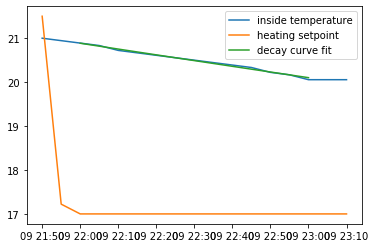

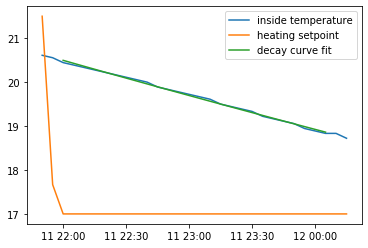

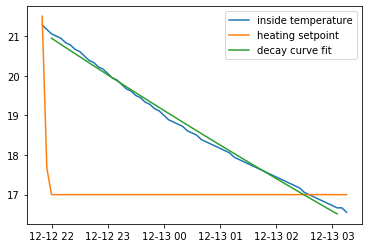

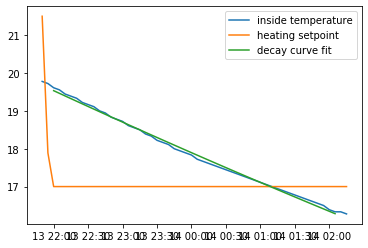

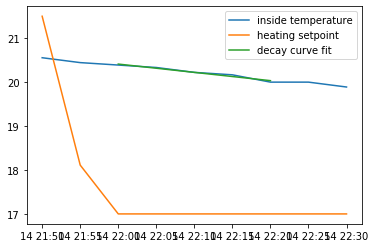

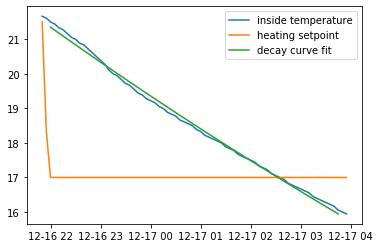

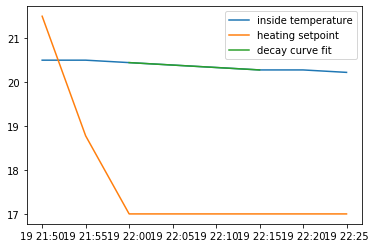

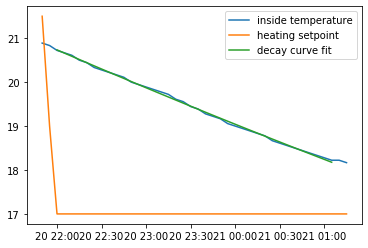

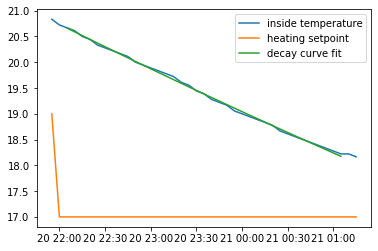

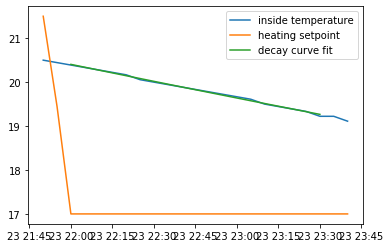

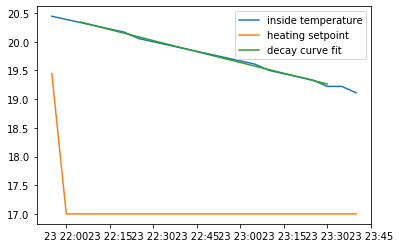

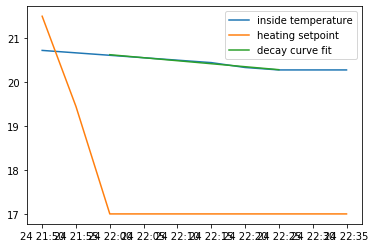

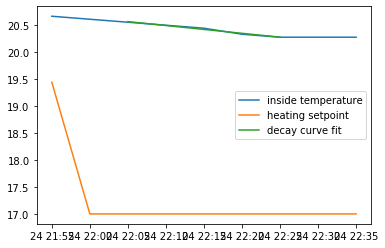

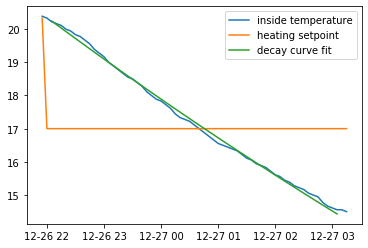

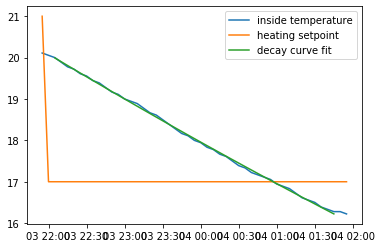

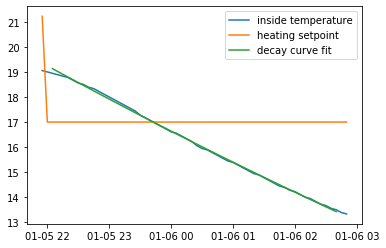

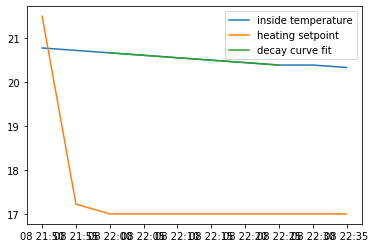

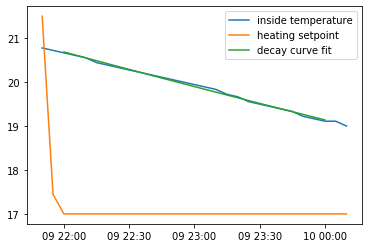

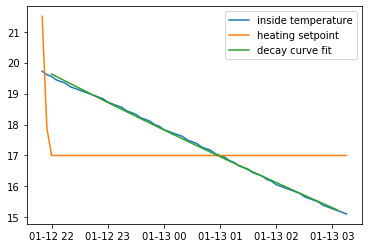

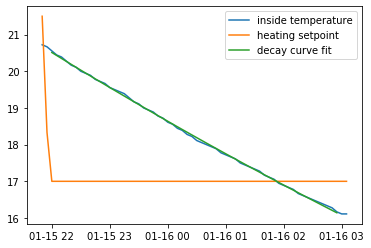

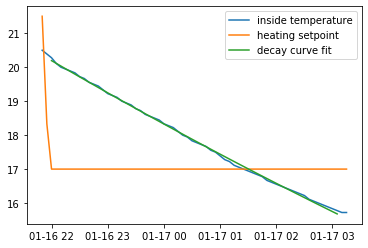

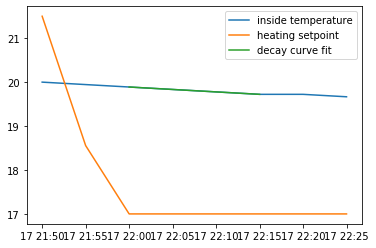

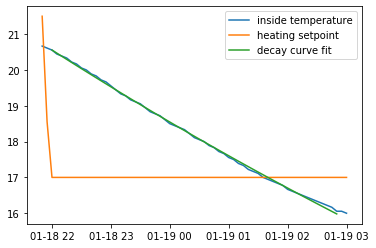

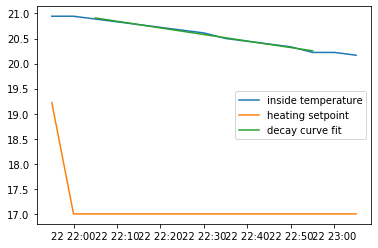

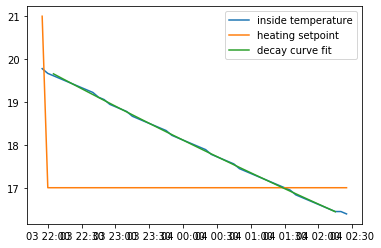

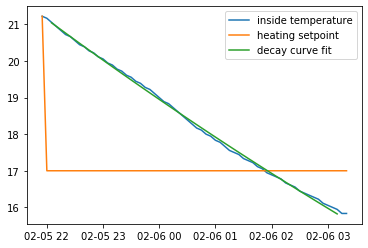

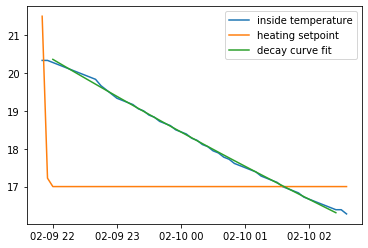

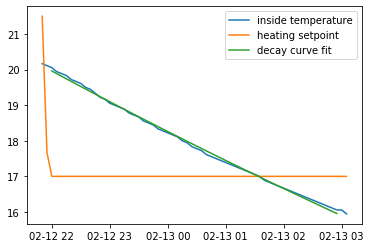

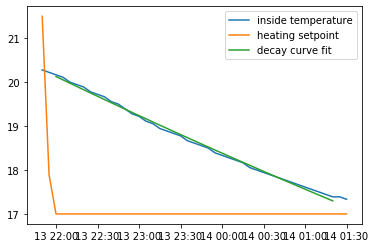

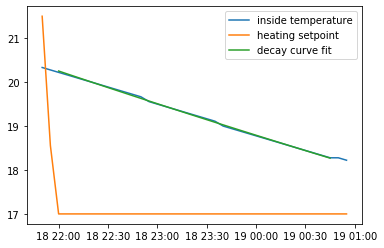

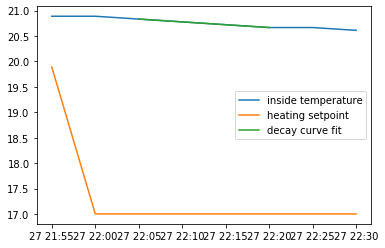

In [4]:
for start_time, end_time in intervals:
    df_slice = df[start_time:end_time]
    
    # plot the original data
    enlarged_df_slice = df[start_time - pd.Timedelta(10, 'min') : end_time+pd.Timedelta(10, 'min')]
    plt.plot(enlarged_df_slice.index, enlarged_df_slice["Thermostat_Temperature"], label = "inside temperature")
    plt.plot(enlarged_df_slice.index, enlarged_df_slice["T_stp_heat"], label = "heating setpoint")
    xdata = np.arange(0, (len(df_slice)*5) - 1, 5.0)
    
    # fit the model
    result = dc.fit_decay_curve(df_slice)
    result_dict = dc.result_to_dict(None, None, None, None, result)
    tau = result_dict.get('tau')
    theta0 = result_dict.get("T0")
    tau_variance = result_dict.get("tau_variance")
#     print('tau', tau, 'theta0', theta0, 'tau_variance', tau_variance)
    y = []
    for x in xdata:
        ydata = dc.decay_curve(x, tau, theta0)
        y.append(ydata)
    y = np.array(y)
    T_out_mean = df_slice["T_out"].mean()
    y = y + T_out_mean
    
    # plot the decay curve
    plt.plot(df_slice.index, y, label = "decay curve fit")
    plt.legend()
    plt.show()